In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!ls "/content/drive/My Drive/evodata"

X1.h5  Y1.h5


In [0]:
# !mkdir data

In [0]:
# !cp "/content/drive/My Drive/evodata/Y1.h5" data/
# !cp "/content/drive/My Drive/evodata/X1.h5" data/

In [0]:
# !ls data

X1.h5  Y1.h5


In [0]:
# !chmod 777 data/X1.h5
# !chmod 777 data/Y1.h5

In [1]:
!pip install scikit-multilearn
!pip install numpy==1.15.4
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
from torch.autograd import Variable
from skmultilearn.problem_transform import LabelPowerset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
# from skmultilearn.problem_transform import LabelPowerset

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


     |████████████████████████████████| 13.9MB 8.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4


In [0]:
with pd.HDFStore("/content/drive/My Drive/evodata/Y1.h5",  mode='r') as store:
    Y = store.select('Y')

with pd.HDFStore("/content/drive/My Drive/evodata/X1.h5",  mode='r') as store:
    X = store.select('X')
        

In [0]:
# with pd.HDFStore('evo/Y1.h5',  mode='r') as store:
#     Y = store.select('Y')
    
# with pd.HDFStore('evo/X1.h5',  mode='r') as store:
#     X = store.select('X')    

In [0]:
X['InclusionBodiesProbPos'] = (X['InclusionBodiesProbability']>=0)*X['InclusionBodiesProbability']
X['InclusionBodiesProbNeg'] = (X['InclusionBodiesProbability']<0)*X['InclusionBodiesProbability']

def location_type_numeric(x1):
    
    if x1 == '0':
        return 1
    elif x1 == 'SignalP_gram_plus_S':
        return 2
    elif x1 == 'SignalP_gram_minus_S':
        return 3
    elif x1 == 'T4SEpre_bpbAac_T4SE':
        return 4
    elif x1 == 'hmmsearch_Tat':
        return 5
    elif x1 == 'T3_MM_T3SS':
        return 6
    elif x1 == 'SignalP_gram_plus_S':
        return 7
    elif x1 == 'hmmsearch_T6S':
        return 8
    elif x1 == 'hmmsearch_T1S':
        return 9
    else:
        raise Exception(x1)
        
X['loc_type_numeric'] = X['loc_type'].apply(location_type_numeric)


In [0]:
Y.sort_values('cluster', inplace=True)
X.sort_values('cluster_is', inplace=True)

In [0]:
Y.drop('cluster', inplace=True,axis=1)
X.drop(['cluster_is', 'InclusionBodiesProbability', 'loc_type' ], inplace=True,axis=1)

In [0]:
labels_on_sums = Y.sum(axis=0)
labels_on_sums.sort_values(ascending=False, inplace=True)

In [0]:
x1 = labels_on_sums > 1000

In [9]:
x1[0:5]

go_9401     True
go_45454    True
go_105      True
go_6265     True
go_9231     True
dtype: bool

In [0]:
valid_labels = labels_on_sums[x1]

In [12]:
valid_labels[0:5]

go_9401     168838
go_45454    134060
go_105       83332
go_6265      69816
go_9231      66419
dtype: int64

In [0]:
columsn_to_drop = [col for col in Y.columns if  col not in valid_labels]

In [0]:
Y.drop(columsn_to_drop, inplace=True,axis=1)

In [15]:
Y.shape

(2528843, 245)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

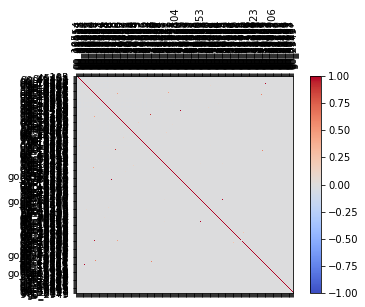

In [23]:
from matplotlib import pyplot as plt

corr = y_train.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(Y.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(Y.columns)
ax.set_yticklabels(Y.columns)
plt.show()

In [0]:
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=3)
prediction = classifier.fit(X_train.values, y_train.values)
#.predict(X_test)

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [0]:
alg = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [0]:
alg.fit(X_train, y_train['go_9401'], eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=140, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.6, verbosity=1)

In [0]:
predictions = alg.predict(X_test)
pred_proba = alg.predict_proba(X_test)[:, 1]

In [0]:
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.metrics import classification_report_imbalanced




/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
print("acc : %.4g" % metrics.accuracy_score(y_test['go_9401'], predictions))
print("roc_auc %f" % metrics.roc_auc_score(y_test['go_9401'], pred_proba))
print("F1 Score : %f" % metrics.f1_score(y_test['go_9401'], predictions))

acc : 0.9851
AUC 0.991573
F1 Score : 0.880308


In [0]:
for label, count in labels_on_sums.items():
    alg = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
    
    alg.fit(X_train, y_train[label], eval_metric='auc')
    predictions = alg.predict(X_test)
    print('****************************************************')
    print('label {0} with rows {1}'.format(label, count))
    
    print("acc : %.4g" % metrics.accuracy_score(y_test[label], predictions))
    print("AUC %f" % metrics.roc_auc_score(y_test[label], pred_proba))
    print("F1 Score : %f" % metrics.f1_score(y_test[label], predictions))
    print(classification_report_imbalanced(y_test[label], predictions))

    print('****************************************************')
    
    

****************************************************
label go_9401 with rows 168838
acc : 0.9851
AUC 0.991573
F1 Score : 0.880308
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.82      0.99      0.90      0.83    707882
          1       0.95      0.82      1.00      0.88      0.90      0.80     50771

avg / total       0.98      0.99      0.83      0.98      0.90      0.83    758653

****************************************************
****************************************************
label go_45454 with rows 134060
acc : 0.9827
AUC 0.583986
F1 Score : 0.815040
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      1.00      0.72      0.99      0.85      0.74    718273
          1       0.94      0.72      1.00      0.82      0.85      0.70     40380

avg / total       0.98      0.98      0.73      0.98      0.85      0.73    758653

****************

KeyboardInterrupt: 

In [0]:
#chain classifier
labels_order = []
for label, count in valid_labels.items():
    
    my_index = y_train.columns.tolist().index(label)
    labels_order.append(my_index)
    

In [0]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier use any other classifier if u wish
#classifier = ClassifierChain(GaussianNB())
#classifier = ClassifierChain(DecisionTreeClassifier())

print(1)
algo = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

print(2)
classifier = ClassifierChain(algo, order=labels_order)
#classifier = ClassifierChain(algo)

print(3)
# train
classifier.fit(X_train, y_train)
print(4)

1
2
3


In [0]:
X_train.ndim,y_train.ndim

(2, 2)

In [0]:
# predict
predictions = classifier.predict(x)
accuracy_score(y,predictions)